In [1]:
import PIL
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import src.datasets.transforms as T
import src.util.misc as utils
from typing import Dict
from pathlib import Path
from dataclasses import dataclass
from pycocotools import mask as coco_mask
from torch.utils.data import DataLoader

### Arguments for dataset

In [2]:
@dataclass
class args:
    coco_path: str="balloon"
    masks: bool=True
    batch_size: int=4
    num_workers: int=0

args = args()

### Dataset

In [3]:
class ConvertCocoPolysToMask(object):
    def __init__(self, return_masks=False):
        self.return_masks = return_masks

    @staticmethod
    def convert_coco_poly_to_mask(segmentations, height, width):
        masks = []
        for polygons in segmentations:
            rles = coco_mask.frPyObjects(polygons, height, width)
            mask = coco_mask.decode(rles)
            if len(mask.shape) < 3:
                mask = mask[..., None]
            mask = torch.as_tensor(mask, dtype=torch.uint8)
            mask = mask.any(dim=2)
            masks.append(mask)
        if masks:
            masks = torch.stack(masks, dim=0)
        else:
            masks = torch.zeros((0, height, width), dtype=torch.uint8)
        return masks

    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if 'iscrowd' not in obj or obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        if self.return_masks:
            segmentations = [obj["segmentation"] for obj in anno]
            masks = self.convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        if self.return_masks:
            masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        if self.return_masks:
            target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] if "iscrowd" in obj else 0 for obj in anno])
        target["area"] = area[keep]
        target["iscrowd"] = iscrowd[keep]

        target["orig_size"] = torch.as_tensor([int(h), int(w)])
        target["size"] = torch.as_tensor([int(h), int(w)])

        return image, target

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        img_folder: str,
        ann_file: str,
        transforms: T.Compose,
        return_masks: bool
    ) -> None:
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms
        self.prepare = ConvertCocoPolysToMask(return_masks)

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        img, target = self.prepare(img, target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target

def make_coco_transforms(image_set):
    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]

    if image_set == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomSelect(
                T.RandomResize(scales, max_size=1333),
                T.Compose([
                    T.RandomResize([400, 500, 600]),
                    T.RandomSizeCrop(384, 600),
                    T.RandomResize(scales, max_size=1333),
                ])
            ),
            normalize,
        ])

    if image_set == 'val':
        return T.Compose([
            T.RandomResize([800], max_size=1333),
            normalize,
        ])

    raise ValueError(f'unknown {image_set}')

def build_dataset(image_set, args):
    root = Path(args.coco_path)
    assert root.exists(), f'provided COCO path {root} does not exist'
    PATHS = dict(
        train=(
            root / "train",
            root / "train" / "train.json"
        ),
        val=(
            root / "val",
            root / "val" / "val.json"
        )
    )
    img_folder, ann_file = PATHS[image_set]
    dataset = CocoDetection(
        img_folder, 
        ann_file,
        transforms=make_coco_transforms(image_set), 
        return_masks=args.masks
    )
    return dataset

### Check data shape

In [4]:
dataset_train = build_dataset(image_set='train', args=args)
dataset_val = build_dataset(image_set='val', args=args)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, 
    args.batch_size, 
    drop_last=True
)

data_loader_train = DataLoader(
    dataset_train, 
    batch_sampler=batch_sampler_train,
    collate_fn=utils.collate_fn, 
    num_workers=args.num_workers
)

data_loader_val = DataLoader(
    dataset_val, 
    args.batch_size, 
    sampler=sampler_val,
    drop_last=False, 
    collate_fn=utils.collate_fn, 
    num_workers=args.num_workers
)

In [6]:
for data in data_loader_train:
    nested_imgs, targets = data
    imgs, masks = nested_imgs.decompose()
    break

# print shape
print(f"batch size: {args.batch_size}")
print(f"{'imgs':10s}: {imgs.shape}")
print(f"{'masks':10s}: {masks.shape}")
print("")

for i, target in enumerate(targets):
    print(f"batch ({i})")
    print(f"Target shape, ({len(target['labels'])}) annotations")
    for key in target.keys():
        print(f"{key:10s}:{target[key].shape}")
    print("")

batch size: 4
imgs      : torch.Size([4, 3, 1066, 901])
masks     : torch.Size([4, 1066, 901])

batch (0)
Target shape, (2) annotations
boxes     :torch.Size([2, 4])
labels    :torch.Size([2])
masks     :torch.Size([2, 640, 806])
image_id  :torch.Size([1])
area      :torch.Size([2])
iscrowd   :torch.Size([2])
orig_size :torch.Size([2])
size      :torch.Size([2])

batch (1)
Target shape, (3) annotations
boxes     :torch.Size([3, 4])
labels    :torch.Size([3])
masks     :torch.Size([3, 736, 901])
image_id  :torch.Size([1])
area      :torch.Size([3])
iscrowd   :torch.Size([3])
orig_size :torch.Size([2])
size      :torch.Size([2])

batch (2)
Target shape, (2) annotations
boxes     :torch.Size([2, 4])
labels    :torch.Size([2])
masks     :torch.Size([2, 1066, 800])
image_id  :torch.Size([1])
area      :torch.Size([2])
iscrowd   :torch.Size([2])
orig_size :torch.Size([2])
size      :torch.Size([2])

batch (3)
Target shape, (1) annotations
boxes     :torch.Size([1, 4])
labels    :torch.Size([

### Check transformed image and target

In [7]:
def graph(
    img: torch.Tensor,
    target: Dict[str, torch.Tensor]
) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))

    img = torch.clone(img)
    img = img.permute(1, 2, 0).numpy()
    img -= np.min(img)
    img /= np.max(img)
    ax.imshow(img)

    y, x = target["size"].numpy()    
    for bbox, mask in zip(target["boxes"], target["masks"]):
        cx, cy, w, h =  bbox
        x0 = x*(cx - 0.5*w)
        y0 = y*(cy - 0.5*h)
        width = x*w
        height = y*h
        rect = patches.Rectangle(
            (x0, y0), width, height, 
            linewidth=1, 
            edgecolor='blue', 
            facecolor='skyblue',
            alpha=0.3
        )
        ax.add_patch(rect)

        mask = mask.numpy()
        mask = np.where(mask==True, 1, np.nan)
        # ax.imshow(mask, cmap="bwr", alpha=0.3)
    plt.show()

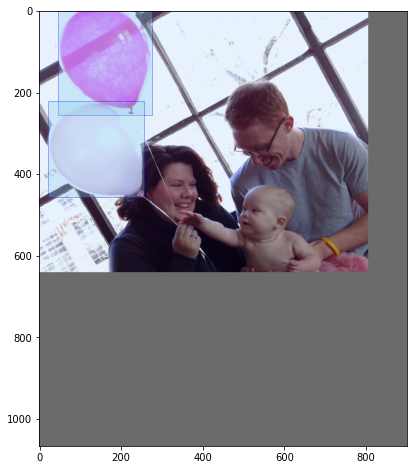

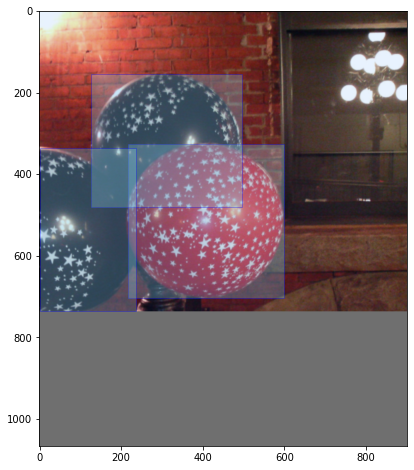

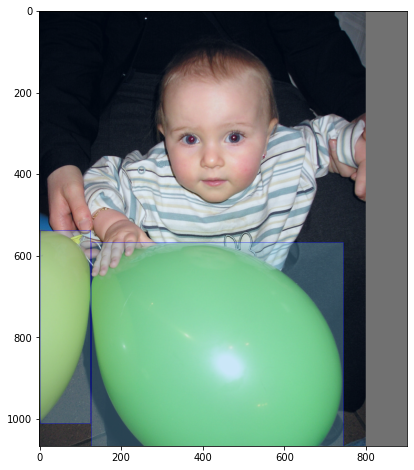

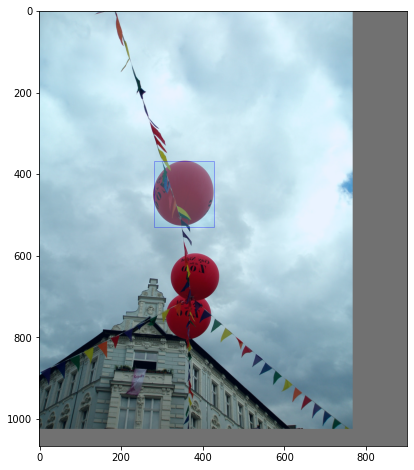

In [8]:
for img, target in zip(imgs, targets):
    graph(img, target)